<a href="https://colab.research.google.com/github/QueenieeQ/image_process/blob/master/find_vanishing_point_of_a_road.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import cv2
import numpy
import math
from google.colab.patches import cv2_imshow

Import library

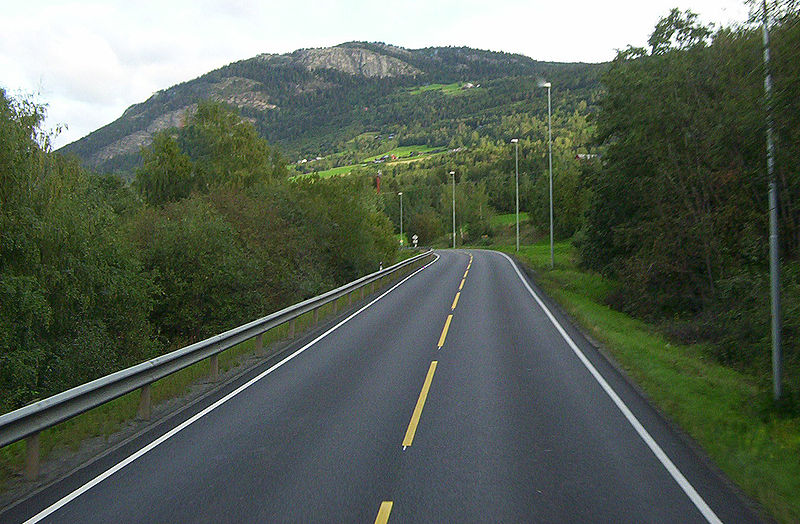

TypeError: cv2_imshow() takes 1 positional argument but 2 were given

In [6]:
# step 1
pic = cv2.imread('/content/Road_image.jpg')
cv2_imshow(pic)
# get image dimensions and color channel
height, width, channels = pic.shape
# declare an empty array variable for grayscale image
grayscale_image = numpy.zeros((height,width), dtype = numpy.uint8)

# interate over every pixel from top to bottom, left to right and apply luminance formula
for row in range(height):
    for collum in range(width):
        # take r,g,b value
        r,g,b = pic[row,collum]
        # calculate grayscale luminance
        grayscale_value = int(0.299 * r + 0.587 * g + 0.114 * b)
        # save the grayscale value to new image
        grayscale_image[row, collum] = grayscale_value
cv2_imshow('1. grayscale image', grayscale_image)

place holder text

In [ ]:
# step 2
# get grayscaled image size
height, width = grayscale_image.shape
#sobel_kernel horizontal an vertical formula
sobel_x_kernel = numpy.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
sobel_y_kernel = numpy.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
# empty array to sore data
sobel_x = numpy.zeros_like(grayscale_image, dtype=numpy.float32)
sobel_y = numpy.zeros_like(grayscale_image, dtype=numpy.float32)
# convolution image
# start from 1 because inoring image borders
for row in range(1, height -1):
    for column in range(1, width - 1):
        # get sourounding 3x3 region from pixel
        region = grayscale_image[row - 1: row +2, column -1: column+2]
        #calculate horizontal and vertical kernel
        result_x = numpy.sum(region*sobel_x_kernel)
        result_y = numpy.sum(region*sobel_y_kernel)
        # save result
        sobel_x[row, column] = result_x
        sobel_y[row, column] = result_y
# calculate gradient magnitude
sobel_magnitude = numpy.sqrt((sobel_x**2)+(sobel_y**2))
#normalized the magnitude number (0-255)
sobel_magnitude_normalized = numpy.uint8(255 * sobel_magnitude / numpy.max(sobel_magnitude))
# get threshold value
sobel_threshold = int(input("Enter threshold value(50-100):"))
# apply a threshold value to create binary edge iamge
_,binary_output = cv2.threshold(sobel_magnitude_normalized, sobel_threshold, 255, cv2.THRESH_BINARY)

cv2.imshow('2. sobel_filter',binary_output)

place holder text

In [ ]:
# Step 3
# Hough Transform implementation
rho_max=int(numpy.sqrt(height ** 2 + width ** 2)) # maximum posible slope of a line that can be detected in the image
theta_max= 180 # 180 degree
votes = numpy.zeros((2* rho_max, theta_max),dtype=numpy.int32)
# votes for each possible line orientation
# calculate vote in hough transform accumulator
for h in range(height):
    for w in range(width):
        if binary_output[h,w ] > 0:
            for theta in range(0, theta_max):
                theta_radian = numpy.deg2rad(theta)
                rho = int(w * numpy.cos(theta_radian)+ h * numpy.sin(theta_radian))
                rho_index = rho + rho_max
                votes[rho_index, theta] += 1
# print(votes)
# apply threshold to accumulator and detect line
hough_threshold = 200
lines_detected = []
lines = numpy.argwhere(votes > hough_threshold)
#draw detected line on images
for rho_index, theta_index in lines:
    rho = rho_index - rho_max
    # convert rho index bach to to rho
    theta = numpy.deg2rad(theta_index)
    lines_detected.append((rho,theta))
    #convert polar coordinate (rho,theta) to cartesian coordinates to drawing
    x0 = (numpy.cos(theta)) * rho
    y0 = (numpy.sin(theta)) * rho
# calculate 2 point on the line to draw
    x1 = int(x0 + 1000 * (-1*( numpy.sin(theta))))
    y1 = int( y0 +1000 * (1 *( numpy.cos(theta))))
    x2 = int( x0 - 1000 * (-1*( numpy.sin(theta))))
    y2 = int( y0 -1000 * (1 *( numpy.cos(theta))))
    # now draw the line on image using opencv line
    # Or you can draw the line by yourself use bresenham line algorithm
    cv2.line(pic, (x1, y1), (x2, y2), (0,0,255),2 )
cv2.imshow('3. Hough Transform lines', pic)


place holder text

In [ ]:
#step4: find intersections between the lines
intersecs = []
for i in range(len(lines_detected)):
    for j in range(i+1, len(lines_detected)):
        rho1, theta1 = lines_detected[i]
        rho2, theta2 = lines_detected[j]
        # check agngle diff is bigger than 30 degree
        angle_different = abs(numpy.rad2deg(theta1) - numpy.rad2deg(theta2))
        if angle_different > 30:
            line1 = numpy.array([[numpy.cos(theta1),numpy.sin(theta1)],
                                [numpy.cos(theta2), numpy.sin(theta2)]])
            line2 = numpy.array([rho1, rho2])
            # intersecPoint = numpy.linalg.solve(line1,line2)
            # tuple(map(int, intersecs))
            try:
                # Solve for intersection point
                intersecPoint = numpy.linalg.solve(line1, line2)
                intersecPoint = tuple(map(int, intersecPoint))  # Convert to integer tuple
                # Check if intersection point is within image dimensions
                if 0 <= intersecPoint[0] < width and 0 <= intersecPoint[1] < height:
                    intersecs.append(intersecPoint)  # Append to intersecs list
            except numpy.linalg.LinAlgError:
                # Lines are parallel, no intersection
                continue

for point in intersecs:
    cv2.circle(pic, point, 5 , (0,255,0),-1)
cv2.imshow('4. Hough Transform lines and tntersections', pic)


place holder text

In [ ]:
# step 5
# sum all intersection point and compute average position
sum_x = sum(point[0] for point in intersecs)
sum_y = sum(point[1] for point in intersecs)

average_x= sum_x /(len(intersecs))
average_y = sum_y / len(intersecs)
vanishing_point = (average_x, average_y)

# cv2.circle( pic, vanishing_point, 10, (0,0,255), -1 )
cv2.circle(pic, (int(vanishing_point[0]), int(vanishing_point[1])), 5, (255, 0, 0), -1)

print(f" coorditantes: {vanishing_point}")
cv2.imshow('5. Vanishing Point', pic)
cv2.imwrite(f'../images/5. Vanishing_point_threshold_{sobel_threshold}.jpg', pic)